### `SARIMAX` extends the SARIMA Model to include the effect of exogeneous variables(X).
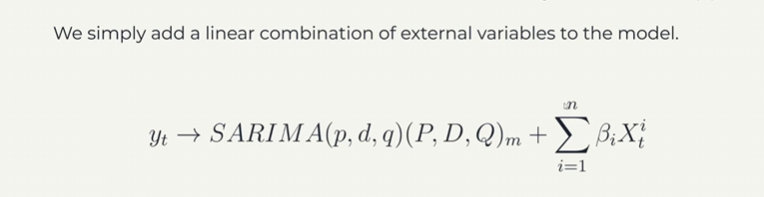

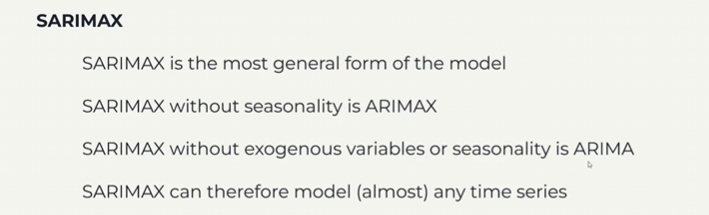

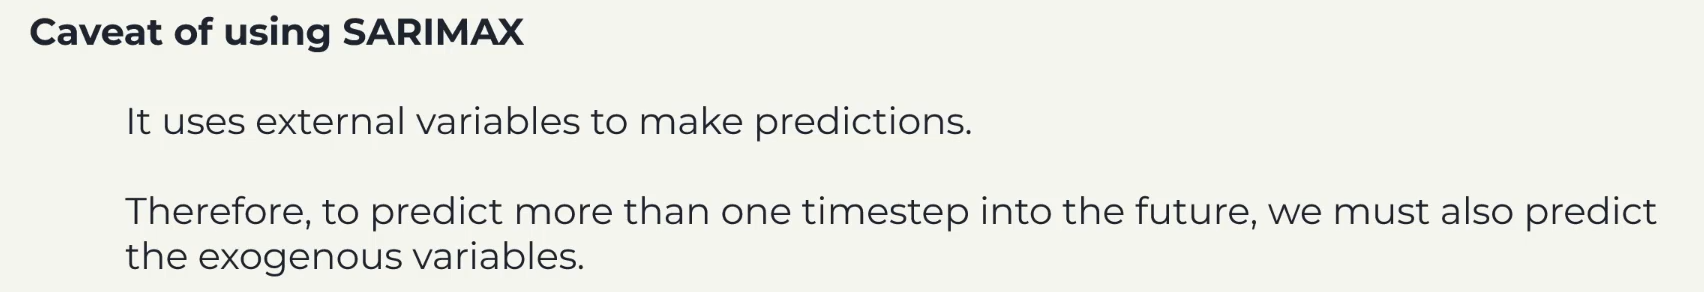

### we must predict `exogeneous variables` if we want to predict `more than 1 timestep`. This may introduce errors in input and errors can accumulate and magnify. So predicting on very long horizons can become very bad.

###  SARIMAX should generally be used for `one-step-ahead forecasting` unless the exogenous variables are easy to predict. 

### For multi-step forecasts, you need future values of X_t (exogenous variables). If these values are unknown or unpredictable, your forecast becomes unreliable.